# Titanic survival 

Predict survival passengers based on the Kaggle dataset

## Import necessary tools

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

## Loading the dataset

In [2]:
df = pd.read_csv('./train.csv',header=0,dtype={'Age': np.float64})
test  = pd.read_csv('./test.csv' , header = 0, dtype={'Age': np.float64})

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.groupby(by=['Pclass','Survived'])['Survived'].agg(['count']).reset_index()

,Pclass,Survived,count
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


### Ticket class

The fraction(mean) of survival for differen ticket classes are shown belowed. 
It is pretty obvious that ticket class is a significant factor to the number of survivals. That is, 63% of 1st class ticket holders survived

In [5]:
ticket_summary = df.groupby(by = ['Pclass'])['Survived'].agg(['mean','sum','count']).reset_index()
ticket_summary

,Pclass,mean,sum,count
0,1,0.629630,136,216
1,2,0.472826,87,184
2,3,0.242363,119,491


### Gender

To evaluate where gender influences the number of survival
In fact, female had higher survival rate

In [6]:
gender_summary = df.groupby(by = ['Sex'])['Survived'].agg(['mean','sum','count']).reset_index()
gender_summary

,Sex,mean,sum,count
0,female,0.742038,233,314
1,male,0.188908,109,577


### Age

The histogram and the percentage of age show that child had higher chance to survive


In [7]:
df = df.dropna(subset=['Age'])
age_summary = pd.DataFrame(df['Age'][(df['Survived']==1)].value_counts().sort_index(ascending=False)).reset_index().rename(columns={'index':'Age','Age':'Number'})

In [8]:
import matplotlib.pyplot as plt

import matplotlib.style as style
%matplotlib inline

(array([69., 16.,  8.,  8.,  9.,  7.,  8.,  4.,  0.,  1.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

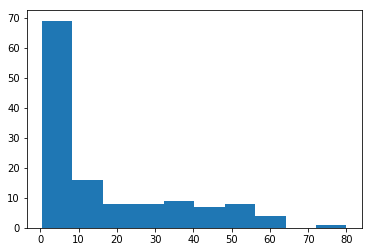

In [9]:
counts, bins = np.histogram(age_summary)
plt.hist(bins[:-1], bins, weights=counts)

In [10]:
binss = [0,6,18,30,50,100]
age_grouped = df.groupby(by = [pd.cut(df['Age'], binss)])['Survived'].agg(['count','mean','sum']).reset_index()

In [11]:
age_grouped

,Age,count,mean,sum
0,"(0, 6]",47,0.702128,33
1,"(6, 18]",92,0.402174,37
2,"(18, 30]",270,0.355556,96
3,"(30, 50]",241,0.423237,102
4,"(50, 100]",64,0.343750,22


### Preprocessing

Drop rows with Age == Nan

Cabin could be a significant factor, but there are many NaN values so this feature will be dropped

In [12]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [13]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          529
Embarked         2
dtype: int64

In [14]:
# Filled all Nan in test and df dataset, not the cabin since most of them are NaNs
df['Embarked'].fillna(df['Embarked'].mode().iloc[0], inplace=True)
test['Age'].fillna(test['Age'].mode().iloc[0],inplace = True)
test['Fare'].fillna(test['Fare'].mode().iloc[0],inplace = True)

In [15]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

#### Convert Age to Categorical features

In [20]:
for data in [test,df]:
    bins = [0, 6, 18, 30, 50,100]
    labels = ['Baby','Young','Teen','Adult','Old']
    data['AgeLabel'] = pd.cut(data['Age'], bins=bins,labels=labels)
    data['AgeLabel'] = data['AgeLabel'].astype(str)

In [21]:
def extracttitle(name):
    x = (name.split(",")[1]).split(" ")[1]
    return(x)

In [22]:
for data in [test,df]:
    data['Title'] = data['Name'].apply(lambda x: extracttitle(x))

In [32]:
df['Title'][df['Survived']==1].value_counts()

df['Title'].value_counts()

Mr.          398
Miss.        146
Mrs.         108
Master.       36
Dr.            6
Rev.           6
Major.         2
Mlle.          2
Col.           2
Sir.           1
the            1
Capt.          1
Mme.           1
Jonkheer.      1
Ms.            1
Don.           1
Lady.          1
Name: Title, dtype: int64

In [33]:
# Replace some of the title according the kernel https://www.kaggle.com/lostrens/titanic-with-simple-scikit-learn/output
all_data = [df,test]
Known = ['Mr.','Miss.','Mrs.','Master.','Ms.','Mlle.','Mme.','Dr.','Sir.','Major.','Rev.']
for k in (all_data):
    for i,data in enumerate(k['Title']):
        if (data) in Known:
            if(data=='Mlle.'):
                k['Title'] = k['Title'].replace('Mlle.','Miss.')
            elif(data=='Ms.'):
                k['Title'] = k['Title'].replace('Ms.','Miss.')
            elif(data=='Mme.'):
                k['Title'] = k['Title'].replace('Mme.','Mrs.')
            else:
                continue
        else:
            k['Title'] = k['Title'].replace(data,'not_known')

In [34]:
df['Title'].value_counts()

Mr.          398
Miss.        149
Mrs.         109
Master.       36
not_known      7
Rev.           6
Dr.            6
Major.         2
Sir.           1
Name: Title, dtype: int64

### If people with higher status had higher chance to survival?

It is shown that man with higher status, e.g. Master, had significant higher chance to survive compare to men with lower status

In [35]:
title_summary = df.groupby(by = ['Title'])['Survived'].agg(['mean','count','sum']).reset_index()
print(title_summary)
print(gender_summary)

       Title      mean  count  sum
0        Dr.  0.500000      6    3
1     Major.  0.500000      2    1
2    Master.  0.583333     36   21
3      Miss.  0.724832    149  108
4        Mr.  0.168342    398   67
5       Mrs.  0.788991    109   86
6       Rev.  0.000000      6    0
7       Sir.  1.000000      1    1
8  not_known  0.428571      7    3
      Sex      mean  sum  count
0  female  0.742038  233    314
1    male  0.188908  109    577


## Evaluate the first model

### Create train and test set with dropping columns that are not used

In [36]:
list(df.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'AgeLabel',
 'Title']

### Convert categorical to binary values

In [37]:
features = ['Pclass','Sex','AgeLabel','Title','Embarked']
target = ['Survived']

df_features = df[features]
df_target = df[target]
blindtest = test[features]
#y_test = test[target]

df_features = pd.get_dummies(df_features,columns=['Sex','Embarked','AgeLabel','Title','Pclass'])
blindtest = pd.get_dummies(blindtest,columns=['Sex','Embarked','AgeLabel','Title','Pclass'])

### Create train and test sets

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(df_features,df_target,test_size = 0.3, random_state=1)

### Logistic regression

In [39]:
LG = linear_model.LogisticRegression()
LG.fit(X_train, Y_train)
LG.score(X_test,Y_test)

/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7953488372093023

### Decission tree

In [40]:
DT = DecisionTreeClassifier()
DT.fit(X_train, Y_train)
DT.score(X_test,Y_test)

0.8465116279069768

In [41]:
from sklearn.model_selection import GridSearchCV
parameters1 = [{'max_depth':np.linspace(1, 15, 15),'min_samples_split': np.linspace(0.1, 1.0, 5, endpoint=True)}]
Grid1 = GridSearchCV(DT, parameters1, cv=4,return_train_score=True,iid=True)

Grid1.fit(X_train,Y_train)
Grid1.score(X_test,Y_test)

0.8046511627906977

In [42]:
Grid1.best_estimator_.score(X_test,Y_test)

0.8046511627906977

### Ensamble

In [43]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)
RF.score(X_test,Y_test)

/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/QD/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8232558139534883

In [44]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,  VotingClassifier

In [45]:
parameters_DC = [{'max_depth':[2,5,10,15,20,50],'min_samples_split': [0.1,0.2,0.5,0.8]}]

paramaters_RF = [{'max_depth':[2,5,10,15,20,50],'min_samples_split': [0.1,0.2,0.5,0.8],'n_estimators':[100]}]

parameters_XGB =[{"learning_rate": [0.05, 0.10, 0.15, 0.20] ,"max_depth": [ 3, 4, 5, 10], "min_child_weight": [3,5,7],"gamma": [ 0.0, 0.1, 0.2 ,0.3],'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],'n_estimator':[50,100,200]}]

parameters_GBC =[{"learning_rate": [0.5, 0.25, 0.1, 0.05, 0.01] ,"max_depth": [ 3, 4, 5, 6], "min_samples_leaf" :[50,100,150],"n_estimators" : [16, 32, 64, 128]}]

parameters_ADA =[{"base_estimator__criterion" : ["gini", "entropy"],"base_estimator__splitter" :   ["best", "random"],"n_estimators": [1, 2],"learning_rate":  [0.0001,0.001, 0.01, 0.1, 1.0]}]

In [48]:
ADA = AdaBoostClassifier(Grid1.best_estimator_)


Grid_ADA = GridSearchCV(ADA,parameters_ADA, cv=4, scoring="accuracy", n_jobs= 4, return_train_score=True,verbose = 1)

Grid_ADA.fit(X_train,Y_train)
Grid_ADA.score(X_test,Y_test)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    8.1s finished
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8232558139534883

In [49]:
GBC = GradientBoostingClassifier()


Grid_GBC = GridSearchCV(GBC,parameters_GBC, cv=4, scoring="accuracy", n_jobs= 4, return_train_score=True,verbose = 1)

Grid_GBC.fit(X_train,Y_train)
Grid_GBC.score(X_test,Y_test)

Fitting 4 folds for each of 240 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 248 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:   18.1s finished
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8046511627906977

In [51]:
from xgboost import XGBClassifier
XGB = XGBClassifier()

Grid_XGB = GridSearchCV(XGB, parameters_XGB, cv=4,scoring="accuracy", n_jobs= 4,return_train_score=True, verbose = 1)
Grid_XGB.fit(X_train, Y_train)
Grid_XGB.score(X_test,Y_test)

Fitting 4 folds for each of 2880 candidates, totalling 11520 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   58.4s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 11520 out of 11520 | elapsed:  7.8min finished
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

0.827906976744186

In [52]:
XGB = XGBClassifier()
parameters3 =[{"learning_rate": [0.05, 0.10, 0.15, 0.20] ,"max_depth": [ 3, 4, 5, 6], "min_child_weight": [3,5,7],"gamma": [ 0.0, 0.1, 0.2 ,0.3],"colsample_bytree" : [ 0.4, 0.5]}]
XGBGrid1 = GridSearchCV(XGB, parameters3, cv=2,return_train_score=True)

XGBGrid1.fit(X_train,Y_train)
XGBGrid1.score(X_test,Y_test)


/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8232558139534883

### Further refine the models

### Consider the number of sibling and family members onboard

In [53]:
df['SibSp'].value_counts()

0    471
1    183
2     25
4     18
3     12
5      5
Name: SibSp, dtype: int64

In [54]:
df['Parch'].value_counts()

0    521
1    110
2     68
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [55]:
df[(df['Survived'] == 1) & (df['SibSp']!=0)].shape[0] / df[df['SibSp']!=0].shape[0]

0.4732510288065844

In [56]:
df[(df['Survived'] == 1) & (df['SibSp']==0)].shape[0] / df[df['SibSp']==0].shape[0]

0.37154989384288745

It shows that people travelled with family had higher chance to survive

In [57]:
for dat in [df,test]:
    dat['Alone'] = 1
    dat['Family'] = dat['SibSp'] + dat['Parch']
    dat['Alone'].loc[dat['Family']>=1]=0

/Users/QD/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [179]:
features = ['Pclass','Sex','AgeLabel','Title','Embarked','Alone']
target = ['Survived']

df_features = df[features]
df_target = df[target]
blindtest = test[features]
#y_test = test[target]

df_features = pd.get_dummies(df_features,columns=['Sex','Embarked','AgeLabel','Title','Pclass'])
blindtest = pd.get_dummies(blindtest,columns=['Sex','Embarked','AgeLabel','Title','Pclass'])

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(df_features,df_target,test_size = 0.3, random_state=1)

### Decision tree

In [188]:
DT2 = DecisionTreeClassifier()

Grid_DC = GridSearchCV(DT2, parameters_DC, cv=4,scoring="accuracy", n_jobs= 4,return_train_score=True, verbose = 1)
#Fit the model
Grid_DC.fit(X_train,Y_train)

# Best estimator parameters
DC_best = Grid_DC.best_estimator_

# Best score for the model with the paramaters
Grid_DC.best_score_


#DT2.score(X_test,Y_test)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:   12.8s finished


0.7715430861723447

In [190]:
DC_best.score(X_test,Y_test)

0.8232558139534883

In [192]:
RF2 = RandomForestClassifier()

Grid_RF = GridSearchCV(RF2, paramaters_RF, cv=4,scoring="accuracy", n_jobs= 4,return_train_score=True, verbose = 1)
#Fit the model
Grid_RF.fit(X_train,Y_train)

# Best estimator parameters
RF_best = Grid_RF.best_estimator_

# Best score for the model with the paramaters
Grid_RF.best_score_

#RF2.fit(X_train, Y_train)
#RF2.score(X_test,Y_test)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    6.1s finished
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7835671342685371

In [193]:
RF_best.score(X_test,Y_test)

0.8

In [194]:
XGB2 = XGBClassifier()


Grid_XGB = GridSearchCV(XGB, parameters_XGB, cv=4,scoring="accuracy", n_jobs= 4,return_train_score=True, verbose = 1)
#Fit the model
Grid_XGB.fit(X_train,Y_train)

# Best estimator parameters
XGB_best = Grid_XGB.best_estimator_

# Best score for the model with the paramaters
Grid_XGB.best_score_


Fitting 4 folds for each of 2880 candidates, totalling 11520 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   34.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   53.9s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed:  7.7mi

0.7855711422845691

In [195]:
XGB_best.score(X_test,Y_test)

0.8232558139534883

In [63]:
pd.crosstab(df['Survived'],df['Embarked'])

Embarked,C,Q,S
Survived,,,
0,51,20,353
1,79,8,203


In [64]:
df.groupby(by = ['Embarked'])['Survived'].agg(['mean','sum','count'])

,mean,sum,count
Embarked,,,
C,0.607692,79,130
Q,0.285714,8,28
S,0.365108,203,556


In [197]:
ADA = AdaBoostClassifier(DC_best)


Grid_ADA = GridSearchCV(ADA,parameters_ADA, cv=4, scoring="accuracy", n_jobs= 4, return_train_score=True,verbose = 1)
Grid_ADA.fit(X_train,Y_train)
ADA_best = Grid_ADA.best_estimator_

ADA_best.score(X_test,Y_test)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    0.9s finished
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8046511627906977

In [198]:
parameters_SVM = {'C': [0.1, 1, 10,50,100], 'gamma' : [0.001, 0.01, 0.1, 1,10,100]}

from sklearn.svm import SVC
SVMC =SVC(probability=True)
Grid_SVC = GridSearchCV(SVMC, parameters_SVM, scoring="accuracy", return_train_score=True,verbose = 1,cv=2)

Grid_SVC.fit(X_train, Y_train)

SVM_best = Grid_SVC.best_estimator_

# Best score
Grid_SVC.best_score_

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-

/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

0.7995991983967936

In [218]:
# Add missing columns in the testset due to one-hot encoding

def add_missing_dummy_columns( d, columns ):
    missing_cols = set( columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0
    return(d)    

In [220]:
blindtest = add_missing_dummy_columns(blindtest,X_train.columns)

In [221]:
set(X_train.columns).issubset(set(blindtest.columns))

True

In [187]:
## Use the first model for prediction submission

#blindtest.drop(columns=['Alone'],inplace = True)
#blindtest

In [254]:
GBC = GradientBoostingClassifier()


Grid_GBC = GridSearchCV(GBC,parameters_GBC, cv=4, scoring="accuracy", n_jobs= 4, return_train_score=True,verbose = 1)

Grid_GBC.fit(X_train,Y_train)

GBC_best = Grid_GBC.best_estimator_

# Best score
Grid_GBC.best_score_

Fitting 4 folds for each of 240 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 623 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:   32.2s finished
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7835671342685371

In [256]:
GBC_best.score(X_train,Y_train)

0.7835671342685371

In [227]:
voting = VotingClassifier(estimators=[('DT', DC_best),('RF', RF_best),('XGB',XGB_best),('SVC',SVM_best),('ADA',ADA_best) ],weights=[1,1,2,2,2], voting='hard', n_jobs=4)

voting_result = voting.fit(X_train, Y_train)
voting_result.score(X_test,Y_test)

/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/QD/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8232558139534883

In [230]:
#set(X_train.columns).issubset
(set(blindtest.columns)).issubset(set(X_train.columns))

True

In [251]:
f_names = X_train.columns
blindtest2 = blindtest[f_names]
XGB_best.predict(blindtest2)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [162]:
results = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':DT.predict(blindtest)})

In [165]:
results.to_csv(r'/Users/QD/Kaggle/titanic/submit.csv',index=False,header=True)

In [252]:
testnew = pd.read_csv('./test.csv' , header = 0, dtype={'Age': np.float64})
result = pd.DataFrame(voting.predict(blindtest2),columns=['Survived'])
submission6 = result.join(testnew['PassengerId']).iloc[:,::-1]

In [253]:
submission6.to_csv('submission5.csv', index=False)